#### Building and training ConvNet for classifying SIGNS dataset using Tensorflow

1) Implementing helper functions which will be used later when training.
2) Implementing ConvNet using Tensorflow


Lets start by loading packages

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd

%matplotlib inline
np.random.seed(1)

Upload training and testing files

In [3]:
from google.colab import files
files.upload()

Saving test_signs.h5 to test_signs.h5
Saving train_signs.h5 to train_signs.h5


Lets load signs dataset

In [0]:
# Function to load the dataset
def load_dataset():
    train_dataset = h5py.File('/content/train_signs.h5', "r")
    
   
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Lets see some images to get an understanding of data

Image is 0


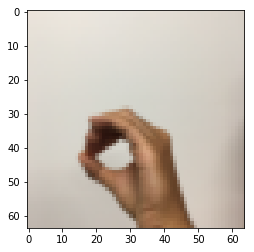

In [6]:
# Example of image
index = 34
plt.imshow(X_train_orig[index])
print('Image is %s' %str(np.squeeze(Y_train_orig[:,34])))

Function to implement one hot encoding of y values

In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

Lets look at shapes of data and normalize them

In [8]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


#### 1.1 Create placeholders

TensorFlow requires that we create placeholders for the input data that will be fed into the model when running the session.

In [0]:
def create_placeholders(n_H, n_W, n_C, n_Y):
  '''
  Create place holders for tensorflow session
  
  Arguments:
  n_H -- scalar, height of input image
  n_W -- scalar, width of input image
  n_C -- scalar, number of channels in input image
  n_Y -- scalar, number of classes
  
  Returns:
  X -- placeholder for the data input, of shape [None, n_H, n_W, n_C] and dtype 'float'
  Y -- placeholder for the input labels, of shape [None, n_Y] and dtype 'float'
  '''
  
  X = tf.placeholder(dtype = 'float', shape = [None, n_H, n_W, n_C])
  Y = tf.placeholder(dtype = 'float', shape = [None, n_Y])
  
  return X, Y  

#### 1.2 Intialize parameters

Lets intialize parameters for the different channels I will use in convolutional layers. I will be building 2 layers of convolutional layers.

In [0]:
def initialize_parameters():
  '''
  Initializes weight parameters to build a neural network with tensorflow.
  Shapes are W1: [4,4,3,8]
             W2: [2,2,8,16]
             
  Returns -- a dictionary of tensors containing W1, W2
  '''
  tf.set_random_seed(1)                 
  
  W1 = tf.get_variable('W1', [4,4,3,8], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
  W2 = tf.get_variable('W2', [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
  
  parameters = {'W1':W1,
                'W2':W2}
  
  return parameters


#### 1.3 Forward propagation

I will be implementing Conv2d -> Relu -> Maxpool -> Conv2d -> Relu -> Maxpool -> Flatten -> Fullyconnected layers.
Depending on training and validation accuracies I will come back and change architecture or number of epochs or learning rate etc.

In [0]:
def forward_propagation(X, parameters):
  """
  Implements the forward propagation for the model:
  Conv2d -> Relu -> Maxpool -> Conv2d -> Relu -> Maxpool -> Flatten -> Fullyconnected
  
  Arguments:
  X -- input dataset placeholder, of shape (inputsize, number of examples)
  parameters -- python dictionary containing parameters 'W1', 'W2'
  
  Returns:
  Z3 -- output of last Linear unit
  """
  
  # Retrieve parameters from dictionary 'parameters'
  W1 = parameters['W1']
  W2 = parameters['W2']
  
  # CONV2D: stride of 1, padding 'SAME'
  Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
  # RELU
  A1 = tf.nn.relu(Z1)
  # MAXPOOL: window 8x8, sride 8, padding 'SAME'
  P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
  # CONV2D: filters W2, stride 1, padding 'SAME'
  Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
  # RELU
  A2 = tf.nn.relu(Z2)
  # MAXPOOL: window 4x4, stride 4, padding 'SAME'
  P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
  # FLATTEN
  P2 = tf.contrib.layers.flatten(P2)
  # FULLY-CONNECTED without non-linear activation function.
  # 6 neurons in output layer.
  Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
  
  return Z3

#### 1.4 Compute cost

In [0]:
def compute_cost(Z3, Y):
  """
  Computes the cost
    
  Arguments:
  Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
  Y -- "true" labels vector placeholder, same shape as Z3
    
  Returns:
  cost - Tensor of the cost function
  """
   
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
  return cost

Let's write a function to create a list of random minibatches. Minibatches are 
subset of original data which will be sending to model for training.

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
  """
  Creates a list of random minibatches from (X, Y)
    
  Arguments:
  X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
  Y -- true "label" vector, of shape (1, number of examples) (m, n_y)
  mini_batch_size - size of the mini-batches, integer
    
  Returns:
  mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
  """
    
  m = X.shape[0]                  # number of training examples
  mini_batches = []
  np.random.seed(seed)
    
  # Step 1: Shuffle (X, Y)
  permutation = list(np.random.permutation(m))
  shuffled_X = X[permutation,:,:,:]
  shuffled_Y = Y[permutation,:]

  # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
  num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
  for k in range(0, num_complete_minibatches):
    mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
    mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
  if m % mini_batch_size != 0:
    mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
    mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)
    
  return mini_batches

#### 1.5 Model

Now I will merge all the helper functions implemented above to build a model. Will train on SIGNS dataset.

Function below will

1) Create placeholders
2) Initialize parameters
3) Forward propagate
4) Compute the cost
5) Create an optimizer

Finally I will create a session and run a loop for num_epochs, get mini_batches, and then for each mini_batch I will optimize the function


In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
  
  """
  Implements a three-layer ConvNet in Tensorflow:
  CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
  Arguments:
  X_train -- training set, of shape (None, 64, 64, 3)
  Y_train -- test set, of shape (None, n_y = 6)
  X_test -- training set, of shape (None, 64, 64, 3)
  Y_test -- test set, of shape (None, n_y = 6)
  learning_rate -- learning rate of the optimization
  num_epochs -- number of epochs of the optimization loop
  minibatch_size -- size of a minibatch
  print_cost -- True to print the cost every 100 epochs
    
  Returns:
  train_accuracy -- real number, accuracy on the train set (X_train)
  test_accuracy -- real number, testing accuracy on the test set (X_test)
  parameters -- parameters learnt by the model. They can then be used to predict.
  """
    
  ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
  tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
  seed = 3                                          # to keep results consistent (numpy seed)
  (m, n_H, n_W, n_C) = X_train.shape
  n_Y = Y_train.shape[1]        
  costs = []                                        # To keep track of the cost
    
  # Create Placeholders of the correct shape
  X, Y = create_placeholders(n_H, n_W, n_C, n_Y)
    
  # Initialize parameters
  parameters = initialize_parameters()
    
  # Forward propagation: Build the forward propagation in the tensorflow graph
  Z = forward_propagation(X, parameters)
    
  # Cost function: Add cost function to tensorflow graph
  cost = compute_cost(Z, Y)
    
  # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
  # Initialize all the variables globally
  init = tf.global_variables_initializer()
    
  # Start the session to compute the tensorflow graph
  with tf.Session() as sess:
      
    # Run the initialization
    sess.run(init)
    
    # Training loop
    for epoch in range(num_epochs):
      
      minibatch_cost = 0.
      num_minibatches = int(m / minibatch_size)      # number of minibatches of size minibatch_size in the train set
      
      seed = seed + 1
      minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
      
      for minibatch in minibatches:
        
        # Select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        # IMPORTANT: The line that runs the graph on a minibatch.
        # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
        ### START CODE HERE ### (1 line)
        _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
        
        minibatch_cost += temp_cost/num_minibatches
        
      # Print the cost every epoch
      if print_cost == True and epoch % 5 == 0:
        print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
      if print_cost == True and epoch % 1 == 0:
        costs.append(minibatch_cost)
        
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    # Calculate the correct predictions
    predict_op = tf.argmax(Z, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    
    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
    test_accuracy = accuracy.eval({X:X_test, Y:Y_test})
    
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    
    return train_accuracy, test_accuracy, parameters
    
        

Run the below cell to train the model for 200 epochs.

Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
Cost after epoch 10: 1.904309
Cost after epoch 15: 1.904477
Cost after epoch 20: 1.901876
Cost after epoch 25: 1.784094
Cost after epoch 30: 1.687814
Cost after epoch 35: 1.617914
Cost after epoch 40: 1.588563
Cost after epoch 45: 1.564673
Cost after epoch 50: 1.551985
Cost after epoch 55: 1.512204
Cost after epoch 60: 1.488463
Cost after epoch 65: 1.368796
Cost after epoch 70: 1.281402
Cost after epoch 75: 1.205087
Cost after epoch 80: 1.119874
Cost after epoch 85: 1.103765
Cost after epoch 90: 1.051161
Cost after epoch 95: 1.012231
Cost after epoch 100: 1.018780
Cost after epoch 105: 0.986617
Cost after epoch 110: 0.980134
Cost after epoch 115: 0.927904
Cost after epoch 120: 0.916281
Cost after epoch 125: 0.898608
Cost after epoch 130: 0.866157
Cost after epoch 135: 0.854542
Cost after epoch 140: 0.866672
Cost after epoch 145: 0.813396
Cost after epoch 150: 0.805220
Cost after epoch 155: 0.797596
Cost after epoch 160: 0.796092

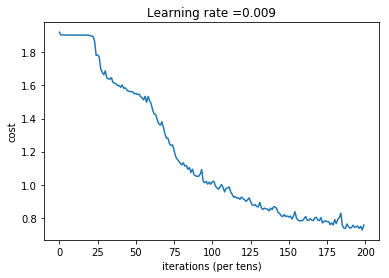

Train Accuracy: 0.73888886
Test Accuracy: 0.60833335


In [0]:
_,_,parameters = model(X_train,Y_train,X_test,Y_test,num_epochs=200)

By looking at cost graph, its getting flattened after 200 epochs. So running for more epochs would not help us. Also train accuracy is around 73% and test is 60%. So my model is suffering from both bias and variance

#### Solving bias problem

Lets build bigger network than previously built

In [0]:
def initialize_parameters():
  '''
  Initializes weight parameters to build a neural network with tensorflow.
  Shapes are W1: [4,4,3,8]
             W2: [2,2,8,16]
             
  Returns -- a dictionary of tensors containing W1, W2
  '''
  tf.set_random_seed(1)                 
  
  W1 = tf.get_variable('W1', [4,4,3,8], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
  W2 = tf.get_variable('W2', [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
  W3 = tf.get_variable('W3', [2,2,16,32], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
  W4 = tf.get_variable('W4', [2,2,32,64], initializer=tf.contrib.layers.xavier_initializer(seed = 0))


  
  parameters = {'W1':W1,
                'W2':W2,
                'W3':W3,
                'W4':W4}
  
  return parameters


In [0]:
def forward_propagation(X, parameters):
  """
  Implements the forward propagation for the model:
  Conv2d -> Relu -> Maxpool -> 
  Conv2d -> Relu -> Maxpool -> 
  Conv2d -> Relu -> Maxpool ->
  Conv2d -> Relu -> Maxpool -> Flatten -> Fullyconnected
  
  Arguments:
  X -- input dataset placeholder, of shape (inputsize, number of examples)
  parameters -- python dictionary containing parameters 'W1', 'W2'
  
  Returns:
  Z3 -- output of last Linear unit
  """
  
  # Retrieve parameters from dictionary 'parameters'
  W1 = parameters['W1']
  W2 = parameters['W2']
  W3 = parameters['W3']
  W4 = parameters['W4']

  # CONV2D: stride of 1, padding 'SAME'
  Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
  # RELU
  A1 = tf.nn.relu(Z1)
  # MAXPOOL: window 8x8, sride 8, padding 'SAME'
  P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
  # CONV2D: filters W2, stride 1, padding 'SAME'
  Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
  # RELU
  A2 = tf.nn.relu(Z2)
  # MAXPOOL: window 4x4, stride 4, padding 'SAME'
  P2 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
  # CONV2D: stride of 1, padding 'SAME'
  Z3 = tf.nn.conv2d(P2, W3, strides = [1,1,1,1], padding = 'VALID')
  # RELU
  A3 = tf.nn.relu(Z3)
  # MAXPOOL: window 4x4, stride 4, padding 'SAME'
  P3 = tf.nn.max_pool(A3, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
  # CONV2D: stride of 1, padding 'SAME'
  Z4 = tf.nn.conv2d(P3, W4, strides = [1,1,1,1], padding = 'VALID')
  # RELU
  A4 = tf.nn.relu(Z4)
  # MAXPOOL: window 4x4, stride 4, padding 'SAME'
  P4 = tf.nn.max_pool(A4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
  print(P4.shape)
  # FLATTEN
  P4 = tf.contrib.layers.flatten(P4)
  # FULLY-CONNECTED without non-linear activation function.
  # 6 neurons in output layer.
  Z = tf.contrib.layers.fully_connected(P4, 6, activation_fn=None)
  
  return Z

(?, 3, 3, 64)
Cost after epoch 0: 1.899868
Cost after epoch 5: 0.480988
Cost after epoch 10: 0.057787
Cost after epoch 15: 0.057408
Cost after epoch 20: 0.002708
Cost after epoch 25: 0.001951
Cost after epoch 30: 0.001842
Cost after epoch 35: 0.001787
Cost after epoch 40: 0.001738
Cost after epoch 45: 0.001698
Cost after epoch 50: 0.001658
Cost after epoch 55: 0.001616
Cost after epoch 60: 0.001575
Cost after epoch 65: 0.001747
Cost after epoch 70: 0.001492
Cost after epoch 75: 0.001450
Cost after epoch 80: 0.001404
Cost after epoch 85: 0.001361
Cost after epoch 90: 0.001317
Cost after epoch 95: 0.001269


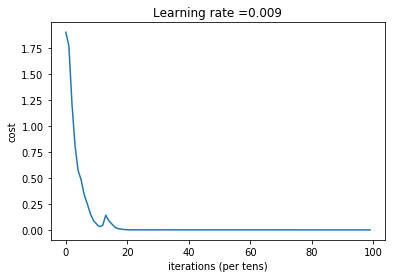

Train Accuracy: 1.0
Test Accuracy: 0.9166667


In [0]:
_,_,parameters = model(X_train,Y_train,X_test,Y_test,num_epochs=100)

Since I saw problem of bias in my model, I went for bigger architecture with smaller filters in both convolutional and max pooling layers. Above we can see huge improvement in accuracies of both training and testing sets. Training accuracy went to 100% from 73%.

#### Solving variance/overfitting problem

Sometimes training for more number of epochs can cause model to overfit. Lets add functionality of plotting test cost to the model() function to understand when the model started overfitting.

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True, plot_graph = True):
   
  """
  Implements a three-layer ConvNet in Tensorflow:
  CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
  Arguments:
  X_train -- training set, of shape (None, 64, 64, 3)
  Y_train -- test set, of shape (None, n_y = 6)
  X_test -- training set, of shape (None, 64, 64, 3)
  Y_test -- test set, of shape (None, n_y = 6)
  learning_rate -- learning rate of the optimization
  num_epochs -- number of epochs of the optimization loop
  minibatch_size -- size of a minibatch
  print_cost -- True to print the cost every 100 epochs
    
  Returns:
  train_accuracy -- real number, accuracy on the train set (X_train)
  test_accuracy -- real number, testing accuracy on the test set (X_test)
  parameters -- parameters learnt by the model. They can then be used to predict.
  """
    
  ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
  tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
  seed = 3                                          # to keep results consistent (numpy seed)
  (m, n_H, n_W, n_C) = X_train.shape
  n = X_test.shape[0]
  n_Y = Y_train.shape[1]        
  costs = []                                        # To keep track of the cost
  costs_test = []  
  # Create Placeholders of the correct shape
  X, Y = create_placeholders(n_H, n_W, n_C, n_Y)
    
  # Initialize parameters
  parameters = initialize_parameters()
    
  # Forward propagation: Build the forward propagation in the tensorflow graph
  Z = forward_propagation(X, parameters)
    
  # Cost function: Add cost function to tensorflow graph
  cost = compute_cost(Z, Y)
    
  # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
  # Initialize all the variables globally
  init = tf.global_variables_initializer()
    
  # Start the session to compute the tensorflow graph
  with tf.Session() as sess:
      
    # Run the initialization
    sess.run(init)
    
    # Training loop
    for epoch in range(num_epochs):
      
      minibatch_cost = 0.
      num_minibatches = int(m / minibatch_size)      # number of minibatches of size minibatch_size in the train set
      
      seed = seed + 1
      minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
      
      for minibatch in minibatches:
        
        # Select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        # IMPORTANT: The line that runs the graph on a minibatch.
        # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
        ### START CODE HERE ### (1 line)
        _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
        
        minibatch_cost += temp_cost/num_minibatches
     
    #######
      minibatch_test_cost = 0
      num_minibatches_test = int(n/minibatch_size)
      
      seed = seed + 1
      
      minibatches_test = random_mini_batches(X_test, Y_test, minibatch_size, seed)
      
      for minibatch_test in minibatches_test:
        # Select a minibatch
        (minibatch_test_X, minibatch_test_Y) = minibatch_test
        test_cost = sess.run(cost, feed_dict = {X:minibatch_test_X, Y:minibatch_test_Y})
        
        minibatch_test_cost += test_cost/num_minibatches_test
        
    ######     
      #Print the cost every epoch
      if print_cost == True and epoch % 5 == 0:
        print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
      if epoch % 1 == 0:
        costs.append(minibatch_cost)
        costs_test.append(minibatch_test_cost)
    
    if plot_graph == True:
      #plot the cost
      plt.plot(np.squeeze(costs), label = 'training cost')
      plt.plot(np.squeeze(costs_test), label = 'test cost')
      plt.legend(loc = 'upper right')
      plt.ylabel('cost')
      plt.xlabel('iterations (per tens)')
      plt.xticks(np.arange(0,num_epochs, step = 5))
      plt.title("Learning rate =" + str(learning_rate))
      plt.show()
    
    # Calculate the correct predictions
    predict_op = tf.argmax(Z, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    
    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
    test_accuracy = accuracy.eval({X:X_test, Y:Y_test})
    
    print('\n')
    print("Learning_rate:", learning_rate)
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    print('\n')
    
    return train_accuracy, test_accuracy, parameters, costs, costs_test
    
        

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(?, 3, 3, 64)
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.900184
Cost after epoch 5: 0.400623
Cost after epoch 10: 0.121547
Cost after epoch 15: 0.066411
Cost after epoch 20: 0.029287
Cost after epoch 25: 0.056025
Cost after epoch 30: 0.032788
Cost after epoch 35: 0.001913
Cost after epoch 40: 0.001746
Cost after epoch 45: 0.001678
C

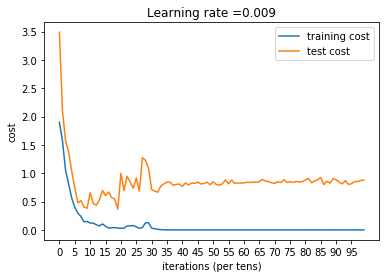



Learning_rate: 0.009
Train Accuracy: 1.0
Test Accuracy: 0.93333334




In [18]:
_,_,parameters,_,_ = model(X_train,Y_train,X_test,Y_test,num_epochs=100)